# GC Stratify

Stratify early open peaks by GC content and see iPSC accessibility for each GC bucket.

In [736]:
library(ggplot2)
library(DESeq2)
library(dplyr)
library(patchwork)

In [2]:
cts <- read.csv("./data/bulk.overlap.200bp.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,D0,D2,D4,D6,D8,D10,D12,D14,iPSC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 51459 51659,17,7,15,12,20,15,47,99,18
chr1 51689 51889,8,8,12,7,27,34,92,122,33


[1] 536647      9

In [728]:
cts_gc <- read.csv("./data/bulk.overlap.200bp.gc.txt",sep="\t", header=F)
cts_gc$V1 = NULL # row order should be same as that of cts
rownames(cts_gc) = rownames(cts)
colnames(cts_gc) = "GC"
# cts_gc$GC_bucket = ntile(cts_gc$GC, 10)
cts_gc$GC_bucket = cut(cts_gc$GC, c(0,0.35,0.4,0.45,0.5,0.55,0.6,1))
head(cts_gc)

,GC,GC_bucket
,<dbl>,<fct>
chr1 51459 51659,0.535,"(0.5,0.55]"
chr1 51689 51889,0.635,"(0.6,1]"
chr1 51904 52104,0.435,"(0.4,0.45]"
chr1 181046 181246,0.735,"(0.6,1]"
chr1 181268 181468,0.755,"(0.6,1]"
chr1 196449 196649,0.490,"(0.45,0.5]"


In [543]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [544]:
log_norm_cts = log2(1+norm_cts)

In [25]:
quantile(log_norm_cts, c(0.1, 0.5, 0.9))

10%      50%      90% 
4.287387 6.764455 8.965319

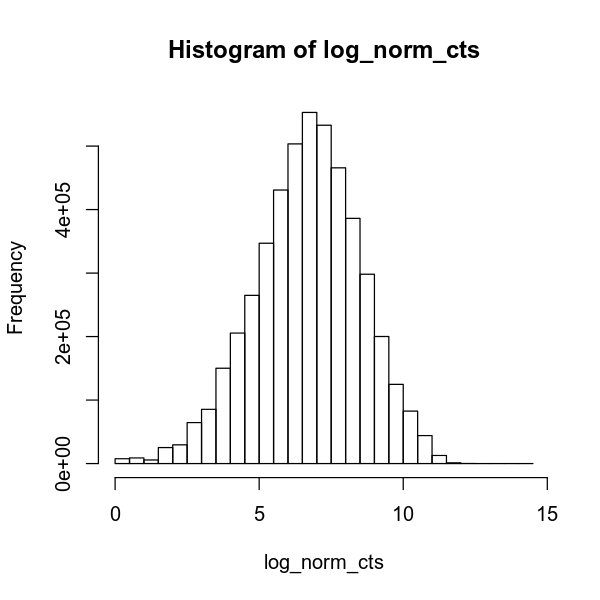

In [24]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(log_norm_cts)

## Remove promoter peaks

In [ ]:
library(EnsDb.Hsapiens.v86)

In [306]:
edb <- EnsDb.Hsapiens.v86

In [307]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))
seqlevels(genes.hg38) = paste("chr", seqlevels(genes.hg38), sep='')

In [308]:
prom.hg38 = promoters(genes.hg38, upstream = 5000, downstream = 1000)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 5 out-of-bound ranges located on sequences
  chrKI270721.1, chrKI270734.1, and chrMT. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."


In [310]:
intervals_gr = GRanges(sub("\t", "-", sub("\t", ":", rownames(cts))))

In [311]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 88082 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2           4
      [2]         2           5
      [3]         6          66
      [4]         6          67
      [5]         6          68
      ...       ...         ...
  [88078]     22261      536631
  [88079]     22261      536632
  [88080]     22262      536636
  [88081]     22262      536637
  [88082]     22262      536638
  -------
  queryLength: 22285 / subjectLength: 536647

In [313]:
dim(cts[-(unique(subjectHits(overlaps))),])

[1] 459449      9

In [729]:
norm_cts_no_prom = norm_cts[-(unique(subjectHits(overlaps))),]
log_norm_cts_no_prom = log_norm_cts[-(unique(subjectHits(overlaps))),]
cts_gc_no_prom = cts_gc[-(unique(subjectHits(overlaps))),]
# cts_gc_no_prom$GC_bucket = ntile(cts_gc_no_prom$GC, 10)

## Plotting

In [875]:
make_violin_plot <- function(gc_buckets, cts, title) {
    p <- ggplot(data.frame(x=as.factor(gc_buckets),
                      y=cts), 
           aes(x=x, y=y)) +
#         ylim(c(0,10)) +
        coord_cartesian(ylim=c(0,10)) +
        theme_classic() +
#         geom_violin(fill="black") + 
        stat_boxplot(geom = "errorbar", width = 0.2) +
        geom_boxplot() + 
        xlab("Peak GC Content") +
        ylab("Normalized Log2 Counts") + 
        ggtitle(title) +
        theme(
    #           plot.margin = margin(5,1,5,1, "cm"),
#               axis.text.x = element_text(angle = 0, hjust = 1),
              plot.title = element_text(hjust = 0.5, size=20),
              axis.ticks.x=element_blank(),
              legend.position = "none"
    );  
    p
}

In [897]:
peak_subset = (log_norm_cts_no_prom[,"D0"] < quantile(log_norm_cts_no_prom[,"D0"], .2)) #& (log_norm_cts_no_prom[,"D2"] > quantile(log_norm_cts_no_prom, 0.5))

In [898]:
gsub("\t", " ", head(sample(rownames(log_norm_cts_no_prom)[peak_subset])))

[1] "chr1 47984706 47984906"   "chr2 80364615 80364815"  
[3] "chr4 127518438 127518638" "chr8 16083221 16083421"  
[5] "chr2 198861168 198861368" "chr5 18526862 18527062"

In [899]:
sum(peak_subset)

[1] 91857

In [900]:
quantile(cts_gc_no_prom[peak_subset, "GC"],seq(0,1,.1))

0%   10%   20%   30%   40%   50%   60%   70%   80%   90%  100% 
0.220 0.345 0.375 0.400 0.425 0.445 0.465 0.485 0.515 0.555 0.890

In [901]:
100*table(cts_gc_no_prom[peak_subset,]$GC_bucket)/sum(peak_subset)


  (0,0.35] (0.35,0.4] (0.4,0.45] (0.45,0.5] (0.5,0.55] (0.55,0.6]    (0.6,1] 
 11.920703  18.391630  23.533318  22.155089  13.646211   6.387102   3.965947 

In [902]:
gc_bucket = ntile(cts_gc_no_prom[peak_subset, "GC"],10)

bucket_quantiles = quantile(cts_gc_no_prom[peak_subset, "GC"], seq(0,1,0.1))
bucket_labels = c()
for (i in seq(1,length(bucket_quantiles)-1)) {
    bucket_labels = c(bucket_labels, paste(bucket_quantiles[i], bucket_quantiles[i+1], sep='-'))
}
gc_bucket = factor(bucket_labels[gc_bucket], levels=bucket_labels)

# Just use original manual GC bucket
#gc_bucket = cts_gc_no_prom[peak_subset,]$GC_bucket

d0_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"D0"], "D0")
d2_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"D2"], "D2")
ipsc_violin = make_violin_plot(gc_bucket, log_norm_cts_no_prom[peak_subset,"iPSC"], "iPSC")

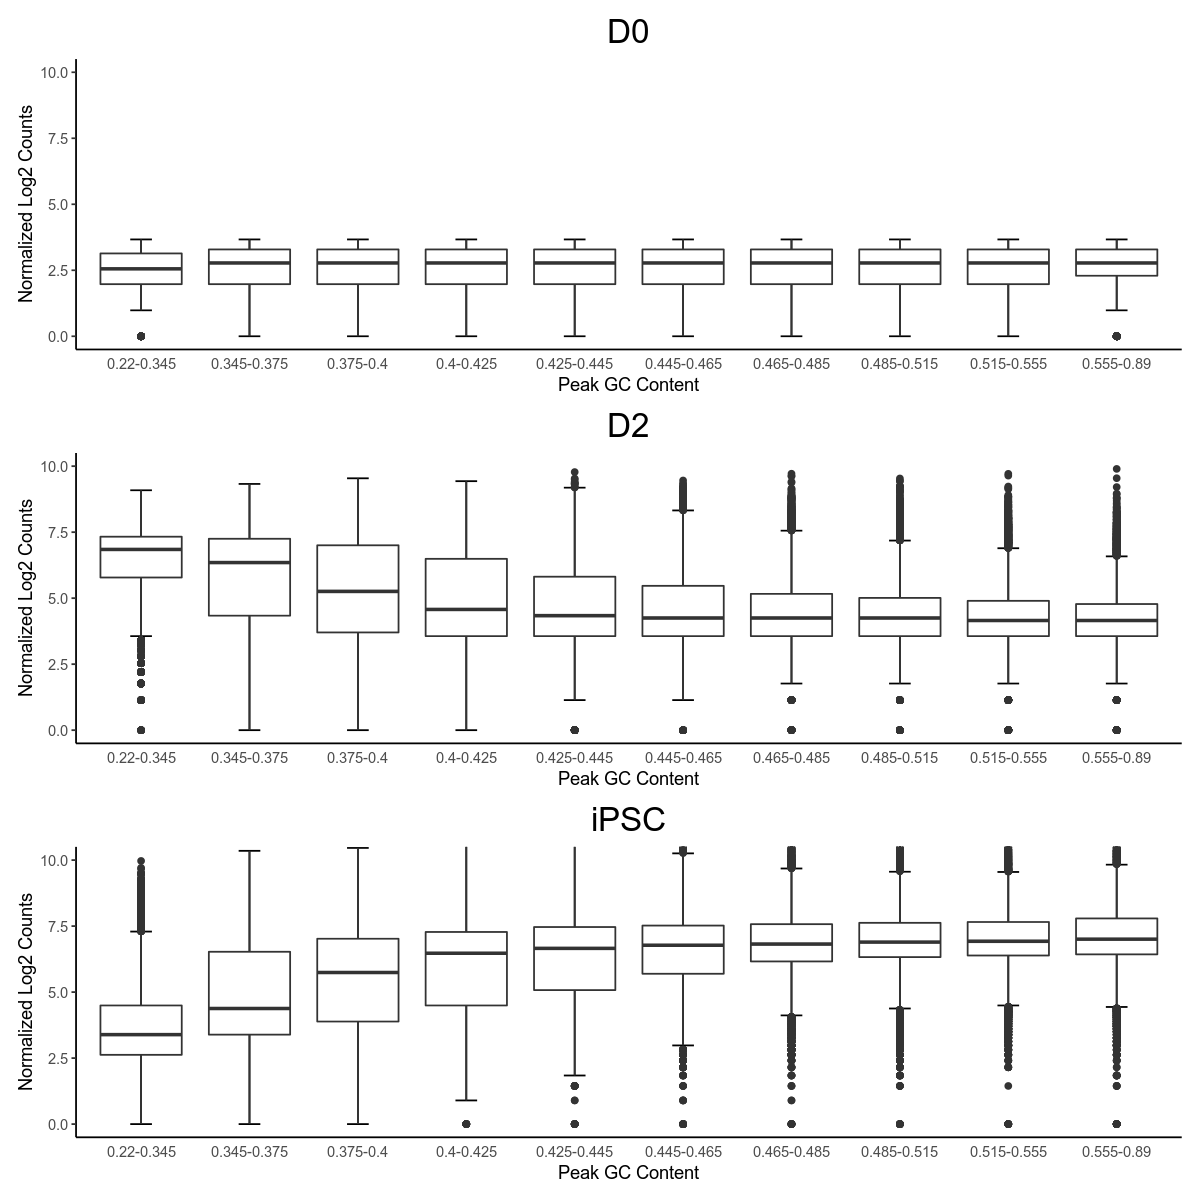

In [903]:
options(repr.plot.width = 10, repr.plot.height = 10)
d0_violin / d2_violin / ipsc_violin

In [848]:
PREFIX = 'D0_lt_0.2_D2_gt_0.5_quantile'
BED_PATH = sprintf("beds/%s_%s_gc%d/", format(Sys.Date(), format='%Y%m%d'), PREFIX, length(levels(gc_bucket)))
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200403_D0_lt_0.2_D2_gt_0.5_quantile_gc10/"

In [849]:
for (i in levels(gc_bucket)){
    BED_PATH = sprintf("beds/%s_%s_gc%d/gc_%s.bed", format(Sys.Date(), format='%Y%m%d'), PREFIX, length(levels(gc_bucket)), sub('-', '_', i))
    fileConn = file(BED_PATH)
    writeLines(rownames(cts_gc_no_prom)[peak_subset][(gc_bucket==i)], fileConn)
    close(fileConn)
}

In [850]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_gc%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), PREFIX, length(levels(gc_bucket)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(cts_gc_no_prom)[peak_subset], fileConn)
close(fileConn)

[1] "beds/20200403_D0_lt_0.2_D2_gt_0.5_quantile_gc10/all_peaks.bed"


In [851]:
cor(cts_gc_no_prom[peak_subset, "GC"], log_norm_cts_no_prom[peak_subset,"D0"], method='spearman')
cor(cts_gc_no_prom[peak_subset, "GC"], log_norm_cts_no_prom[peak_subset,"D2"], method='spearman')
cor(cts_gc_no_prom[peak_subset, "GC"], log_norm_cts_no_prom[peak_subset,"iPSC"], method='spearman')

[1] 0.2479805

[1] 0.04567094

[1] 0.4679035

In [577]:
# global trends
cor(cts_gc_no_prom[, "GC"], log_norm_cts_no_prom[,"D0"], method='spearman')
cor(cts_gc_no_prom[, "GC"], log_norm_cts_no_prom[,"D2"], method='spearman')
cor(cts_gc_no_prom[, "GC"], log_norm_cts_no_prom[,"D14"], method='spearman')
cor(cts_gc_no_prom[, "GC"], log_norm_cts_no_prom[,"iPSC"], method='spearman')

[1] 0.1496261

[1] 0.1063922

[1] 0.5168209

[1] 0.5388344

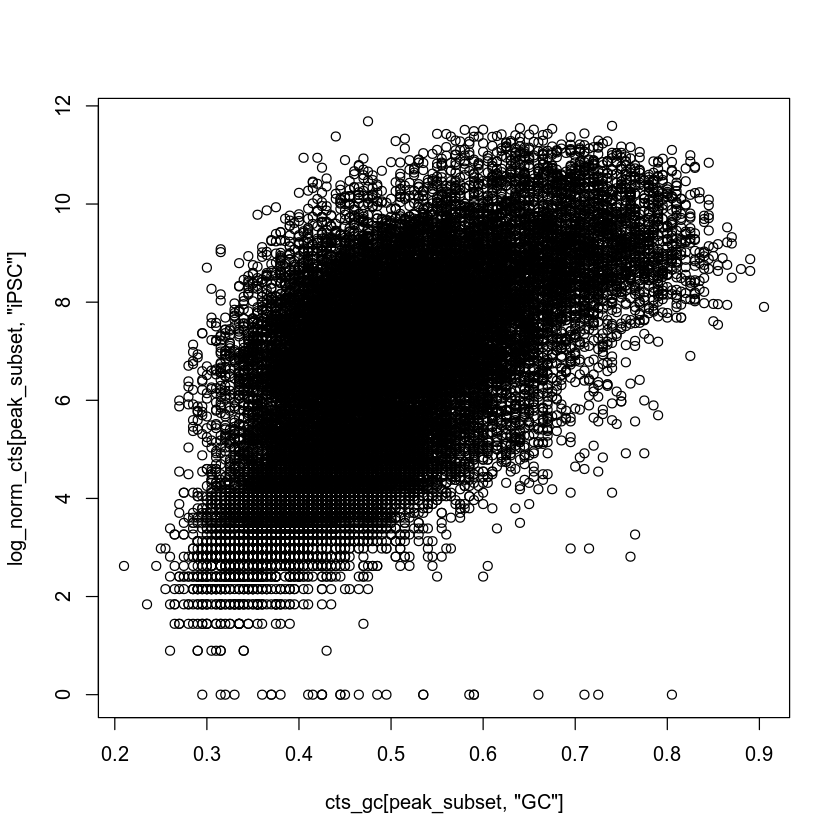

In [759]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(cts_gc[peak_subset, "GC"], log_norm_cts[peak_subset,"iPSC"])

## GC Distribution Around Center

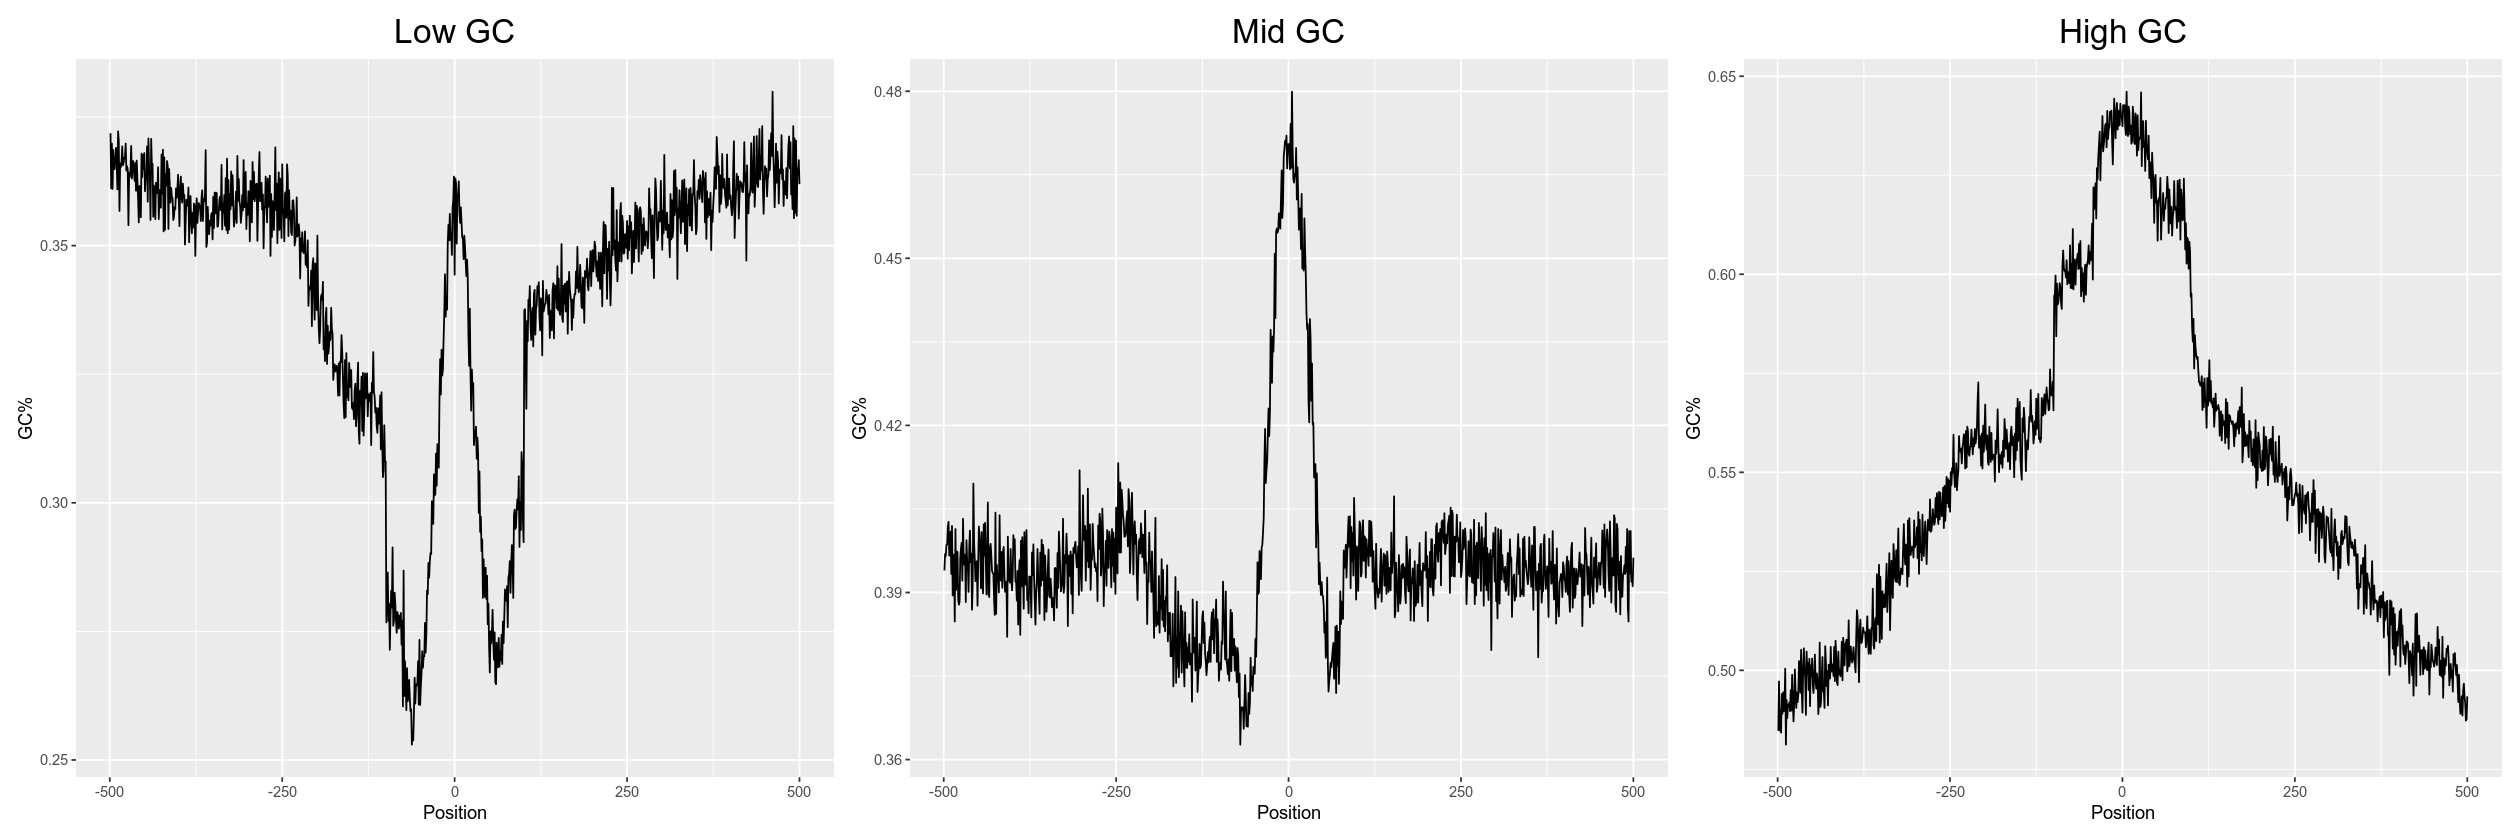

In [907]:
options(repr.plot.width = 21, repr.plot.height = 7)

make_gc_plot <- function(fname, title) {
    gz = gzfile(fname)
    cmeans = colMeans(read.table(gz))
    gcplot <- ggplot(data.frame(x=seq(-499,500),                                
    y=cmeans)) +
    xlab("Position") +
    ylab("GC%") +
    geom_line(aes(x=x,y=y))+
    ggtitle(title) +
    theme(plot.title = element_text(hjust = 0.5, size=20))
    
    gcplot
}

p_low <- make_gc_plot("./gc_mat/20200403_fibr_cluster6_lt_0.2_quantile_gc10/gc_0.1_0.32.1000bp.mat.gz", "Low GC")
p_mid <- make_gc_plot("./gc_mat/20200403_fibr_cluster6_lt_0.2_quantile_gc10/gc_0.395_0.42.1000bp.mat.gz", "Mid GC")
p_high <- make_gc_plot("./gc_mat/20200403_fibr_cluster6_lt_0.2_quantile_gc10/gc_0.56_0.845.1000bp.mat.gz", "High GC")

p_low | p_mid | p_high

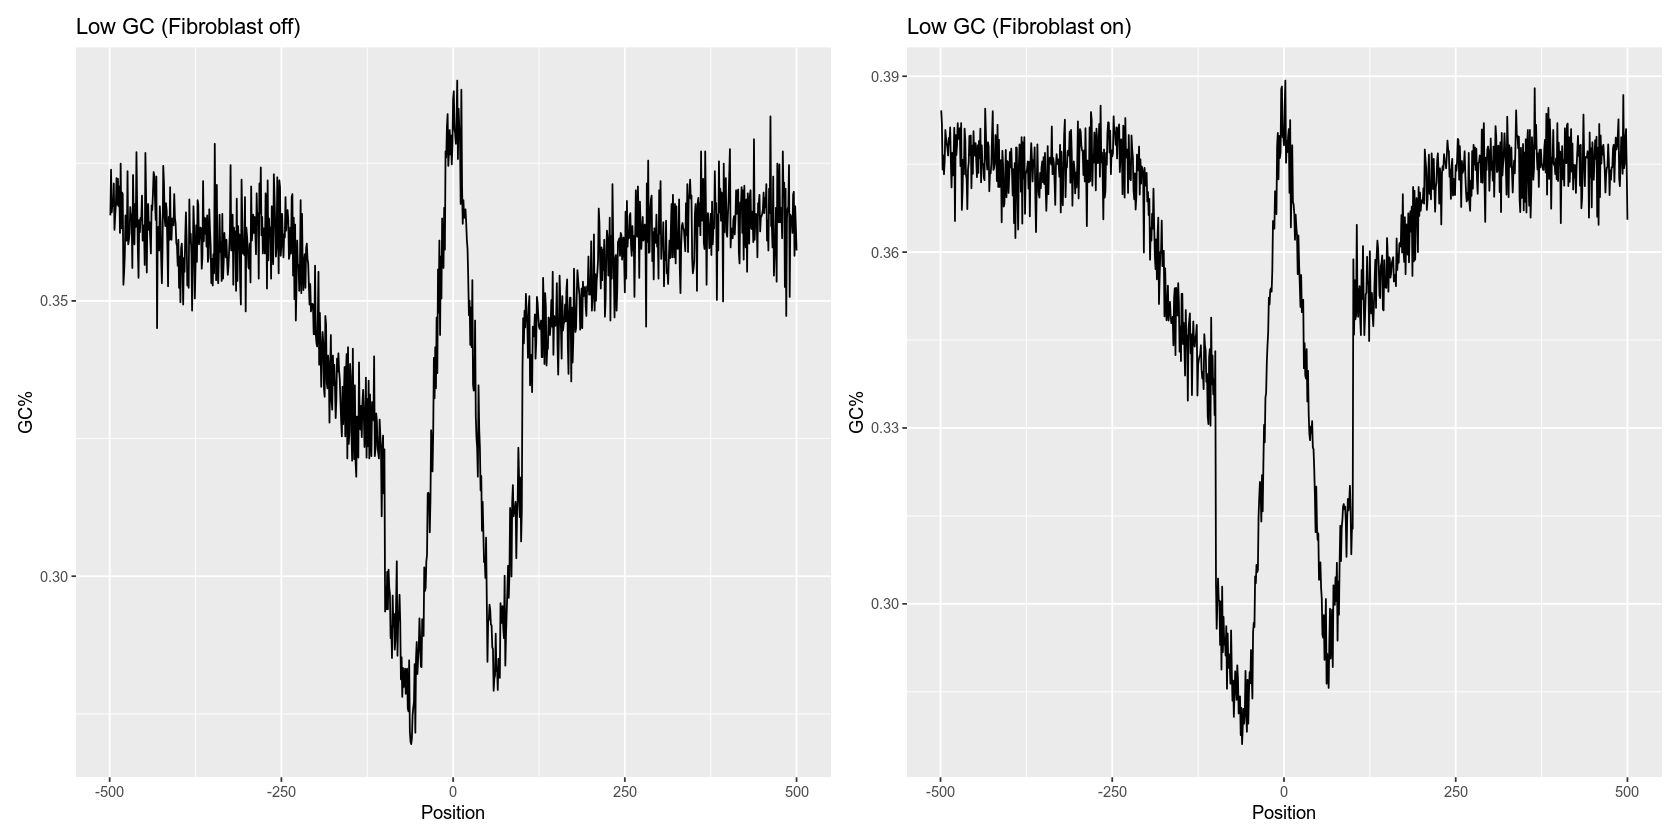

In [781]:
options(repr.plot.width = 14, repr.plot.height = 7)
p_low_D0_off <- make_gc_plot("tmp/tmp.low.gc.1000bp.mat", "Low GC (Fibroblast off)")
p_low_D0_on <- make_gc_plot("tmp/tmp.D0.on.low.gc.1000bp.mat", "Low GC (Fibroblast on)")

p_low_D0_off | p_low_D0_on 